In [1]:
import easyvvuq as uq
import chaospy as cp
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Define campaign
campaign = uq.Campaign(name="sweep", work_dir="campaigns")

# Define parameter space
params = {
    "pthermmw": {"type": "float", "min": 0.0, "max": 1e6, "default": 2.2177e3},
    "etath": {"type": "float", "min": 0.0, "max": 1.0, "default": 4.1100e-1},
    "out_file": {"type": "string", "default": "out.csv"},
}

# Create encoder and decoder
encoder = uq.encoders.GenericEncoder(
    template_fname="water_use.template", delimiter="$", target_filename="in.toml"
)
decoder = uq.decoders.SimpleCSV(
    target_filename="out.csv", output_columns=["water_use_tower"]
)

cwd = str(Path.cwd().resolve())
cmd = f"python {cwd}/water_use.py in.toml"
actions = uq.actions.local_execute(encoder, cmd, decoder)

# Add the app
campaign.add_app(name="water_use", params=params, actions=actions)

# Create PCE sampler
# Only PCE vary etath
# vary = {"pthermmw": cp.Uniform(1e2, 1e3), "etath": cp.Uniform(0.2, 0.45)}
vary = {"etath": cp.Uniform(0.2, 0.45)}
pce_sampler = uq.sampling.PCESampler(vary=vary, polynomial_order=4)

# Try adding a sweep sampler
sweep = {
    # "pthermmw": list(range(1e2, 1e3, 1e2))
    "pthermmw": np.linspace(1e2, 1e3, num=10)
}
sweep_sampler = uq.sampling.BasicSweep(sweep=sweep)

# Create mutli sampler
multi_sampler = uq.sampling.MultiSampler(pce_sampler, sweep_sampler)

# Add multi_sampler to campaign
campaign.set_sampler(multi_sampler)

# Draw samples, execute and collate
campaign.execute().collate(progress_bar=True)
samples = campaign.get_collation_result()


100%|██████████| 40/40 [00:03<00:00, 12.22it/s]


In [3]:
# Print samples
# samples.loc[0:100:10]
samples


,run_id,iteration,etath,pthermmw,out_file,water_use_tower
,0,0,0,0,0,0
0,1,0,0.217358,100.0,out.csv,3327.379481
1,2,0,0.217358,200.0,out.csv,6654.758962
2,3,0,0.217358,300.0,out.csv,9982.138443
3,4,0,0.217358,400.0,out.csv,13309.517924
4,5,0,0.217358,500.0,out.csv,16636.897404
5,6,0,0.217358,600.0,out.csv,19964.276885
6,7,0,0.217358,700.0,out.csv,23291.656366
7,8,0,0.217358,800.0,out.csv,26619.035847
8,9,0,0.217358,900.0,out.csv,29946.415328


In [4]:
# Analysis
# results = campaign.analyse(qoi_cols=["water_use_tower"])
# This doesn't work: "sampler does not have a corresponding analysis class"
# Analysis isn't automatic for a MultiSampler?

# Use old method instead
# Strange [("name", 0)] syntax: hierarchical indexing
analysis = uq.analysis.EnsembleBoot(
    qoi_cols=[("water_use_tower", 0)],
    groupby=[("pthermmw", 0)],
    stat_func=np.mean,
    stat_name="mean",
)
campaign.apply_analysis(analysis)
results = campaign.get_last_analysis()
results


water_use_tower                            
                            0                            
                         mean           low          high
(pthermmw, 0)                                            
100.0             2869.742536   2550.585354   3188.899718
200.0             5739.485072   5101.170708   6377.799436
300.0             8609.227608   7651.756062   9774.418798
400.0            11478.970144  10202.341416  13032.558398
500.0            14348.712680  12744.271785  15944.498589
600.0            17218.455216  15303.512124  19133.398307
700.0            20088.197752  17854.097478  22322.298025
800.0            22957.940288  20404.682832  25511.197743
900.0            25827.682824  22955.268186  28700.097461
1000.0           28697.425359  25505.853540  32581.395994

Text(0.5, 1.0, 'Cooling tower water usage with varying pthermmw, under uncertain etath')

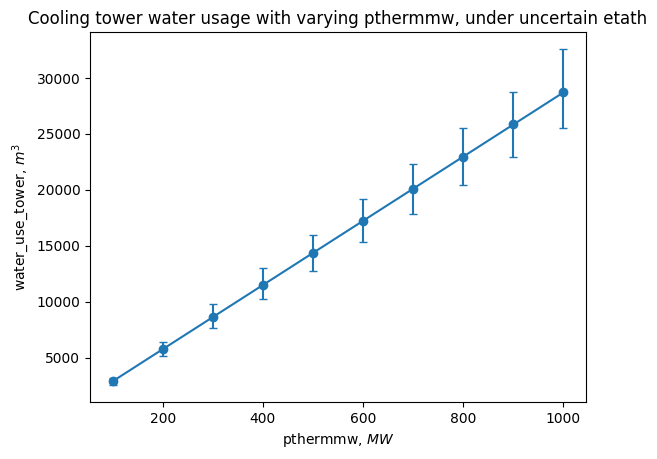

In [18]:
# Plot results
# Think seaborn does this automatically (i.e. bootstrapping)
fig, ax = plt.subplots()
lower_errors = results[("water_use_tower", 0)]["mean"].to_numpy() - results[("water_use_tower", 0)]["low"].to_numpy()
upper_errors = results[("water_use_tower", 0)]["high"].to_numpy() - results[("water_use_tower", 0)]["mean"].to_numpy()
error_bars = np.array([lower_errors, upper_errors])
ax.errorbar(x=results.index.to_numpy(), y=results[("water_use_tower", 0)]["mean"], yerr=error_bars, capsize=3, fmt="o-")
ax.set_xlabel("pthermmw, $MW$")
ax.set_ylabel("water_use_tower, $m^3$")
ax.set_title("Cooling tower water usage with varying pthermmw, under uncertain etath")

Text(0.5, 1.0, 'Cooling tower water usage with varying pthermmw, under uncertain etath')

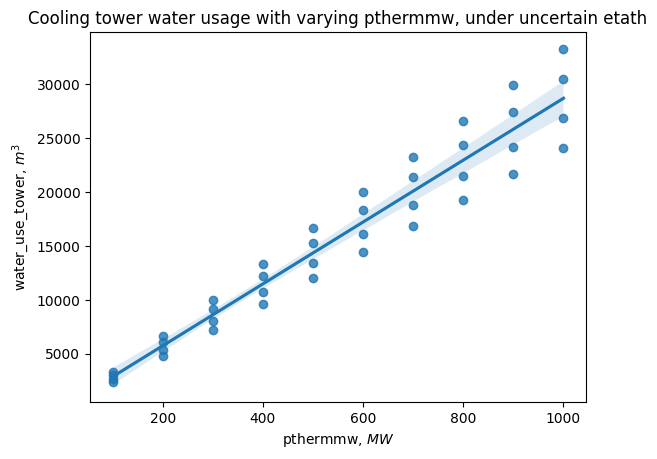

In [24]:
ax = sns.regplot(x=samples["pthermmw"], y=samples["water_use_tower"])
ax.set_xlabel("pthermmw, $MW$")
ax.set_ylabel("water_use_tower, $m^3$")
ax.set_title("Cooling tower water usage with varying pthermmw, under uncertain etath")